# 注意力 Attention

## 1.理论

### 1.1 直观理解

![1](images/seq2seq.jpg)

From：https://arxiv.org/pdf/1703.03906.pdf

![](./images/seq2seq2.gif)

From: https://github.com/google/seq2seq

### 1.2 Attention 计算

加性Attention，如（Bahdanau attention）：

$$
\boldsymbol{v}_a^{\top} \tanh \left(\boldsymbol{W}_{\mathbf{1}} \boldsymbol{h}_t+\boldsymbol{W}_{\mathbf{2}} \overline{\boldsymbol{h}}_s\right)
$$

乘性Attention，如（Luong attention）：

$$
\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}_{t}^{\top} \overline{\boldsymbol{h}}_{s} & \text { dot } \\
\boldsymbol{h}_{t}^{\top} \boldsymbol{W}_{a} \overline{\boldsymbol{h}}_{s} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{a}\left[\boldsymbol{h}_{t} ; \overline{\boldsymbol{h}}_{s}\right]\right) & \text { concat }
\end{array}\right.
$$

### 1.3 自注意力

#### （1）自注意力计算

"Attention is All You Need" 这篇论文提出了Multi-Head Self-Attention，是一种：Scaled Dot-Product Attention。

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

From：https://arxiv.org/pdf/1706.03762.pdf

#### （2）缩放 Scaled

Scaled 的目的是调节内积，使其结果不至于太大（太大的话softmax后就非0即1了，不够“soft”了）。

From: https://kexue.fm/archives/4765

#### （3）Multi-Head


Multi-Head可以理解为多个注意力模块，期望不同注意力模块“注意”到不一样的地方，类似于CNN的Kernel。

>Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions.

$$
\begin{aligned}
\operatorname{MultiHead}(Q, K, V) & =\operatorname{Concat}\left(\operatorname{head}_1, \ldots, \text { head }_{\mathrm{h}}\right) W^O \\
\text { where head }_{\mathrm{i}} & =\operatorname{Attention}\left(Q W_i^Q, K W_i^K, V W_i^V\right)
\end{aligned}
$$



From: https://arxiv.org/pdf/1706.03762.pdf

## 2.实践

### 2.1 包导入

In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from mha import MultiHeadAttention

### 2.2 模型

只用一个核心的SelfAttention模块（可支持Single-Head或Multi-Head），来学习理解Attention机制。

In [3]:
class Model(nn.Module):
    
    def __init__(self, nhead, vocab_size, embedding_dim, num_labels, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.attn = MultiHeadAttention(nhead, embedding_dim, dropout)
        self.fc = nn.Linear(embedding_dim, num_labels)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        h = self.emb(x)
        attn_score, h = self.attn(h)
        h = F.avg_pool1d(h.permute(0, 2, 1), seq_len, 1)
        h = h.squeeze(-1)
        logits = self.fc(h)

        return attn_score, logits

In [4]:
# 参数设置
vocab_size: int = 5000
embedding_dim: int = 512
num_heads: int = 16
dropout: float = 0.1

num_labels: int = 2

max_seq_len: int = 512

num_epochs: int = 10

In [5]:
model = Model(num_heads, vocab_size, embedding_dim, num_labels, dropout)

In [6]:
x = torch.randint(0, 5000, (3, 30))
x.shape

torch.Size([3, 30])

In [7]:
attn, logits = model(x)
attn.shape, logits.shape

(torch.Size([3, 16, 30, 30]), torch.Size([3, 2]))

### 2.3 数据

#### （1）读取数据

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
file_path = "datasets/ChnSentiCorp_htl_all.csv"

df = pd.read_csv(file_path)
df = df.dropna()

In [10]:
df.head(), df.shape

(   label                                             review
 0      1  距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较...
 1      1                       商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
 2      1         早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
 3      1  宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
 4      1               CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风,
 (7765, 2))

In [11]:
df.label.value_counts()

label
1    5322
0    2443
Name: count, dtype: int64

数据不均衡，采样

In [12]:
df = pd.concat([df[df.label==1].sample(2500), df[df.label==0]])
df.shape

(4943, 2)

In [13]:
df.label.value_counts()

label
1    2500
0    2443
Name: count, dtype: int64

#### （2）Tokenizer

In [14]:
from tokenizer import Tokenizer

In [15]:
tokenizer = Tokenizer(vocab_size=vocab_size, max_seq_len=max_seq_len)

In [16]:
tokenizer.build_vocab(df.review)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\dd\AppData\Local\Temp\jieba.cache
Loading model cost 0.470 seconds.
Prefix dict has been built successfully.


In [17]:
tokenizer(["你好", "你好呀"])

tensor([[4436,    0,    0,  ...,    0,    0,    0],
        [4436, 1012,    0,  ...,    0,    0,    0]])

#### （3）数据加载

In [18]:
def collate_batch(batch):
    label_list, text_list = [], []
    for v in batch:
        _label = v["label"]
        _text = v["text"]
        label_list.append(_label)
        text_list.append(_text)
    inputs = tokenizer(text_list)
    labels = torch.LongTensor(label_list)
    return inputs, labels

In [19]:
from dataset import Dataset

ds = Dataset()
ds.build(df, "review", "label")

In [20]:
len(ds), ds[0]

(4943,
 {'text': '4月份回青岛顺便带朋友去玩的，为他们选择的就是该酒店，房间干净整洁，但是卫生间的设施太简陋，房间内有小冰箱，考虑的比较周到，如果卫生间设备好一点就更好了！服务人员的态度非常好，没有给我们青岛人丢脸，电话随叫随到。',
  'label': 1})

In [21]:
train_ds, test_ds = train_test_split(ds, test_size=0.2)
train_ds, valid_ds = train_test_split(train_ds, test_size=0.1)
len(train_ds), len(valid_ds), len(test_ds)

(3558, 396, 989)

In [22]:
from torch.utils.data import DataLoader

In [23]:
BATCH_SIZE = 8

In [24]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
len(train_dl), len(valid_dl), len(test_dl)

(445, 50, 124)

In [25]:
for v in train_dl: break

In [26]:
v[0].shape, v[1].shape, v[0].dtype, v[1].dtype

(torch.Size([8, 512]), torch.Size([8]), torch.int64, torch.int64)

### 2.4 训练

In [27]:
from trainer import train, test

In [34]:
NUM_EPOCHS = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 参数设置
vocab_size: int = 5000
embedding_dim: int = 64
num_heads: int = 2
dropout: float = 0.1
num_labels: int = 2

max_seq_len: int = 512
num_epochs: int = 10

model = Model(num_heads, vocab_size, embedding_dim, num_labels, dropout)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
train(model, optimizer, train_dl, valid_dl, num_epochs)

test(model, test_dl)

Epoch [1/10]
Iter: 445,  Train Loss: 0.60,  Train Acc: 0.75,  Val Loss: 0.49,  Val Acc: 0.77
Epoch [2/10]
Iter: 890,  Train Loss: 0.52,  Train Acc: 0.75,  Val Loss: 0.47,  Val Acc: 0.77
Epoch [3/10]
Iter: 1335,  Train Loss: 0.50,  Train Acc: 0.75,  Val Loss: 0.45,  Val Acc: 0.78
Epoch [4/10]
Iter: 1780,  Train Loss: 0.45,  Train Acc: 0.75,  Val Loss: 0.44,  Val Acc: 0.79
Epoch [5/10]
Iter: 2225,  Train Loss: 0.47,  Train Acc: 0.88,  Val Loss: 0.42,  Val Acc: 0.82
Epoch [6/10]
Iter: 2670,  Train Loss: 0.40,  Train Acc: 0.88,  Val Loss: 0.40,  Val Acc: 0.84
Epoch [7/10]
Iter: 3115,  Train Loss: 0.34,  Train Acc: 0.88,  Val Loss: 0.38,  Val Acc: 0.84
Epoch [8/10]
Iter: 3560,  Train Loss: 0.30,  Train Acc: 0.88,  Val Loss: 0.36,  Val Acc: 0.86
Epoch [9/10]
Iter: 4005,  Train Loss: 0.29,  Train Acc: 0.88,  Val Loss: 0.35,  Val Acc: 0.87
Epoch [10/10]
Iter: 4450,  Train Loss: 0.30,  Train Acc: 0.88,  Val Loss: 0.34,  Val Acc: 0.87


0.815187478500172

### 2.5 推理

In [35]:
from inference import infer
import numpy as np

In [36]:
sample = np.random.choice(test_ds)
while len(sample["text"]) > 20:
    sample = np.random.choice(test_ds)

print(sample)

inp = sample["text"]
inputs = tokenizer(inp)
attn, prob = infer(model, inputs.to(device))
attn_prob = attn[0, 0, :, :].cpu().numpy()
tokens = tokenizer.tokenize(inp)
tokens, prob

{'text': '很适宜居住，环境幽静，服务台较好。我满意', 'label': 1}


(['很', '适宜', '居住', '，', '环境', '幽静', '，', '服务台', '较', '好', '。', '我', '满意'], 1)

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['font.family'] = 'SimHei'

def plot_attention(attention_weights, source_words, target_words):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, interpolation='nearest', cmap='Blues')
    
    plt.xlabel('Source')
    plt.ylabel('Target')

    plt.xticks(np.arange(0, len(source_words)), source_words, rotation=45)
    plt.yticks(np.arange(0, len(target_words)), target_words)
    
    plt.colorbar()
    plt.tight_layout()
    # plt.savefig("a.png")
    plt.show()
    

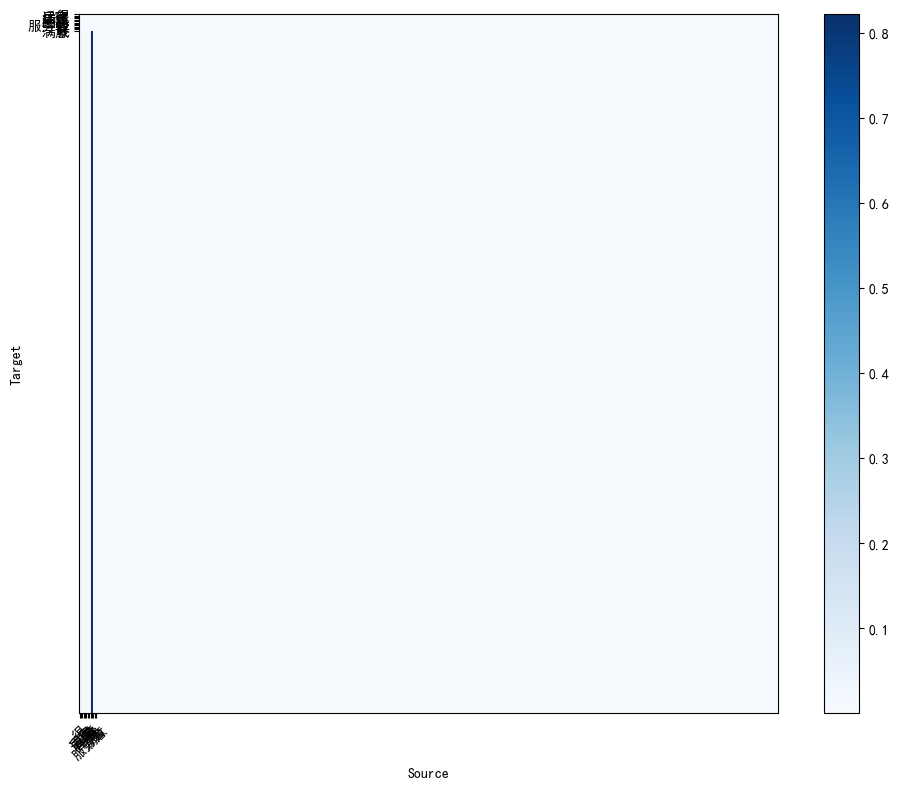

In [38]:
plot_attention(attn_prob, tokens, tokens)

In [39]:
tokenizer.get_freq_of("不")

2682